In [2]:
import requests 
from urllib.parse import urlencode 
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('ggplot')
from scipy.stats import chi2_contingency

 Объявим функцию, позволяющую проверять гипотезы с помощью бутстрапа

In [3]:
"""1. Задаем тестовую (df_test) и контрольную (df_control) выборки, количество бутстрапированных подвыборок (boot_it), 
интересующую статистику (statistic) и уровень значимости (bootstrap_conf_level);
2. Извлекаем подвыборки samples_1 и samples_2, вычисляем разность интересующей нас статистики,
результат записываем в переменную boot_data, создаем датафрейм (pd_boot_data), рассчитываем дов. интервал и p_value;
3. Визуализируем результат."""


def get_bootstrap_mean(
    df_test, 
    df_control, 
    boot_it = 10000, 
    statistic = np.mean,
    bootstrap_conf_level = 0.95 
):
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = df_test.sample(
            len(df_test), 
            replace = True 
        ).values
        
        samples_2 = df_control.sample(
            len(df_test), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
  
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Вводная часть. Считывание данных, предобработка

Считывание users_test c Яндекс Диск:

In [4]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/4XXIME4osGrMRA' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
users_test = pd.read_csv(download_url, sep=';') 
users_test.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [5]:
users_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


Проверка на NA значения:

In [6]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [7]:
users_test.shape

(4308, 13)

Создадим новую колонку с пометкой тестовой группы:

In [8]:
users_test['group'] = 'test'

Проверка на дублирование данных:

In [9]:
users_test.loc[users_test.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group


Считывание users_control_1 c Яндекс Диск:

In [10]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/yJFydMNNGkEKfg' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
users_control_1 = pd.read_csv(download_url, sep=';') 
users_control_1.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


In [11]:
users_control_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [12]:
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

Создадим новую колонку с пометкой контрольной группы №1:

In [13]:
users_control_1['group'] = 'control_1'

Проверка на дубликаты:

In [14]:
users_control_1.loc[users_control_1.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group


Считывание users_control_2 c Яндекс Диск:

In [15]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/br6KkQupzzTGoQ' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
users_control_2 = pd.read_csv(download_url, sep=';') 
users_control_2.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


In [16]:
users_control_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [17]:
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

Проверка на дубликаты

In [18]:
users_control_2.loc[users_control_2.duplicated()]

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue


In [19]:
users_control_2['group'] = 'control_2'
users_control_2.head(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0,control_2
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0,control_2
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0,control_2
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0,control_2
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0,control_2


Рассмотрим таблицы с транзакциями.  
Считывание transactions_test c Яндекс Диск:

In [20]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/gvCWpZ55ODzs2g' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
transactions_test = pd.read_csv(download_url, sep=';') 
transactions_test.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


In [21]:
transactions_test.shape

(273, 8)

In [22]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [23]:
transactions_test.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

Проверка на дубликаты:

In [24]:
transactions_test.loc[transactions_test.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
55,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
96,892050108,Israel,2017-10-22 03:02:00,2017-10-23 02:53:00,1261,19,empty_likes,coins
127,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
158,891508155,Latvia,2017-02-11 09:46:00,2017-03-11 22:06:00,936,19,empty_likes,coins
188,892236423,United States of America,2017-10-18 01:09:00,2017-10-22 22:08:00,1261,19,empty_likes,coins
205,892202526,United States of America,2017-10-18 20:34:00,2017-10-20 19:54:00,897,19,menu,coins
243,892339626,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754,19,empty_likes,coins


Убираем дубликаты:

In [25]:
transactions_test = transactions_test.drop_duplicates() 
transactions_test.shape

(266, 8)

In [26]:
transactions_test['group'] = 'test'
transactions_test.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium,test
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium,test
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type,test
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type,test
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium,test


In [27]:
transactions_test.nunique()

uid             146
country          17
joined_at       146
paid_at         258
revenue         125
payment_id        6
from_page        22
product_type      4
group             1
dtype: int64

Считывание transactions_control_1 c Яндекс Диск:

In [28]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/VY5W0keMX5TZBQ' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
transactions_control_1 = pd.read_csv(download_url, sep=';') 
transactions_control_1.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


In [29]:
transactions_control_1['group'] = 'control_1'

In [30]:
transactions_control_1.shape

(1007, 9)

In [31]:
transactions_control_1.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
group            object
dtype: object

In [32]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
group             0
dtype: int64

В отличии от других рассмотренных таблиц, в данной таблице явно присутствуют 630 пустых строк без каких-либо данных

In [33]:
transactions_control_1_dropna = transactions_control_1.dropna()
transactions_control_1_dropna.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
group           0
dtype: int64

Проверка на дубликаты

In [36]:
transactions_control_1_dropna.loc[transactions_control_1_dropna.duplicated()].head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,control_1
93,891367521.0,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469.0,19.0,sympathy,other_type,control_1
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,control_1
176,892207959.0,France,2017-10-18 18:30:00,2017-10-22 04:49:00,1261.0,19.0,empty_likes,coins,control_1


In [37]:
transactions_control_1 = transactions_control_1_dropna.drop_duplicates()
transactions_control_1.shape

(356, 9)

Считывание transactions_control_2 c Яндекс Диск:

In [38]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/th5GL0mGOc-qzg' 
 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
transactions_control_2 = pd.read_csv(download_url, sep=';') 
transactions_control_2.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [39]:
transactions_control_2['group'] = 'control_2'

In [40]:
transactions_control_2.shape

(328, 9)

In [41]:
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
group           0
dtype: int64

In [42]:
transactions_control_2.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
group           object
dtype: object

Проверка на дубликаты:

In [43]:
transactions_control_2.loc[transactions_control_2.duplicated()]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
86,891862596,Italy,2017-10-26 01:40:00,2017-10-30 09:01:00,1261,19,empty_likes,coins,control_2
235,892064328,United States of America,2017-10-21 20:54:00,2017-10-22 01:30:00,6305,19,empty_likes,coins,control_2
241,892009254,Italy,2017-10-22 22:57:00,2017-10-23 00:06:00,2353,67,empty_likes,other_type,control_2
288,892062660,United States of America,2017-10-21 21:28:00,2017-10-31 00:53:00,1261,19,empty_likes,coins,control_2
321,892045743,Israel,2017-10-22 07:04:00,2017-10-23 20:17:00,1261,19,empty_likes,coins,control_2


In [44]:
transactions_control_2 = transactions_control_2.drop_duplicates()
transactions_control_2.shape

(323, 9)

Объединим в одну таблицу данные о транзакциях:

In [45]:
transactions = pd.concat([transactions_control_1, transactions_control_2, transactions_test])
transactions.head(5)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,control_1
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,control_1
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,control_1
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type,control_1
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,control_1


Сведем все таблицы из категории users в одну таблицу:

In [46]:
users = pd.concat([users_test, users_control_1, users_control_2])
users.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0,test
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0,test


In [47]:
users.shape

(12912, 14)

### Проверим, повлиял ли эксперимент на выручку

Сформируем ряды по выручке в тестовой и контрольных группах:

In [48]:
users_revenue_control_2 = users.query('group == "control_2"').total_revenue
users_revenue_control_1 = users.query('group == "control_1"').total_revenue
users_revenue_test = users.query('group == "test"').total_revenue

Количество пользователей в каждой из групп:

In [49]:
print(f'number users in control_2 {users_revenue_control_2.shape[0]}')
print(f'number users in control_1 {users_revenue_control_1.shape[0]}')
print(f'number users in test {users_revenue_test.shape[0]}')

number users in control_2 4264
number users in control_1 4340
number users in test 4308


Ср.знач. выручки в каждой из групп:

In [50]:
print(f'mean revenue in control_2 {users_revenue_control_1.mean().round(2)}')
print(f'mean revenue in control_1 {users_revenue_control_2.mean().round(2)}')
print(f'mean revenue in test {users_revenue_test.mean().round(2)}')

mean revenue in control_2 594.76
mean revenue in control_1 450.38
mean revenue in test 534.08


Медианное значение выручки в каждой из групп:

In [51]:
print(f'median revenue in control_2 {users_revenue_control_1.median().round(2)}')
print(f'median revenue in control_1 {users_revenue_control_2.median().round(2)}')
print(f'median revenue in test {users_revenue_test.median().round(2)}')

median revenue in control_2 0.0
median revenue in control_1 0.0
median revenue in test 0.0


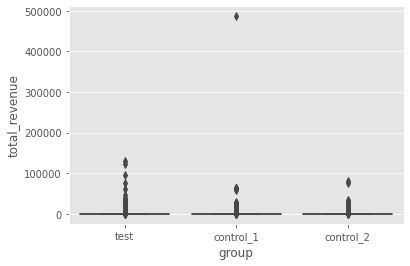

In [52]:
sns.boxplot(x="group", y="total_revenue", data=users)

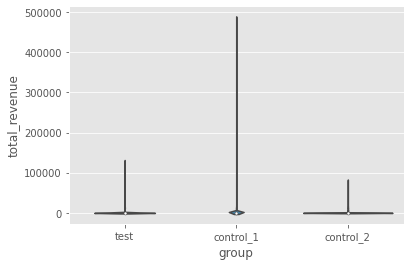

In [53]:
sns.violinplot(x="group", y="total_revenue", data=users)

Проверка на нормальность распределения:

In [54]:
print(ss.normaltest(users_revenue_test))
print(ss.normaltest(users_revenue_control_1))
print(ss.normaltest(users_revenue_control_2))

print(ss.shapiro(users_revenue_test))
print(ss.shapiro(users_revenue_control_1))
print(ss.shapiro(users_revenue_control_2))

NormaltestResult(statistic=8916.392317282456, pvalue=0.0)
NormaltestResult(statistic=13980.768500603957, pvalue=0.0)
NormaltestResult(statistic=7811.263351276203, pvalue=0.0)
ShapiroResult(statistic=0.09913712739944458, pvalue=0.0)
ShapiroResult(statistic=0.03915470838546753, pvalue=0.0)
ShapiroResult(statistic=0.1445736289024353, pvalue=0.0)


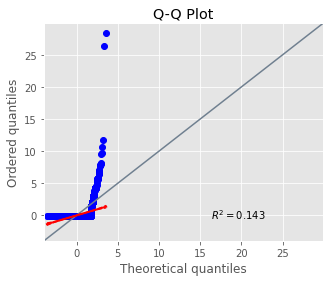

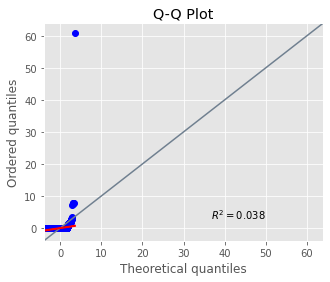

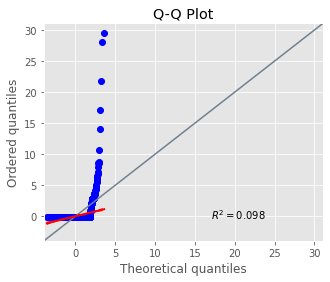

In [55]:
pg.qqplot(users_revenue_control_2)
pg.qqplot(users_revenue_control_1)
pg.qqplot(users_revenue_test)

Все три распределения являются ненормальными.  
Среднее значение выручки 1 контрольной группы больше, чем тестовой, но в 1 контрольной группе есть один пользователь с выручкой почти в 4 раза больше, чем в других группах, что влияет на средний показатель.  
Медианные значения равны нулю.

Проведем А-А тест на 2-х контрольных группах.

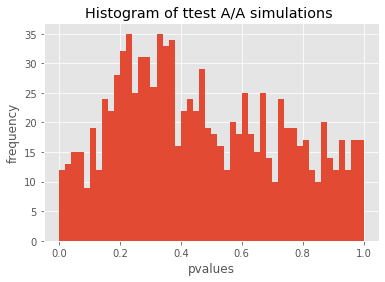

0.032

In [57]:
"""Функция выполняет следующее:
1. На вход задаем количество симуляций и размер выборки;
2. Проводим t-тест для каждой симуляции;
3. Визуализируем результат;
4. Проверяем, что количество ложноположительных случаев не превышает альфа (0,05)"""


simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = users_revenue_control_1.sample(n_s, replace = False).values
    s2 = users_revenue_control_2.sample(n_s, replace = False).values
    res.append(ss.ttest_ind(s1, s2, equal_var = False)[1]) 

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) < 0.05) / simulations

Получили FPR < 0.05. Следовательно, различий между контрольными группами нет, система сплит-алгоритма cработала корректно.

Объединим две контрольные группы в один ряд:

In [58]:
users_revenue_control = pd.concat([users_revenue_control_1, users_revenue_control_2])

Средние значения выручки контрольной и тестовой групп:

In [59]:
print(users_revenue_control.mean().round(4))
print(users_revenue_test.mean().round(4))

523.2107
534.0803


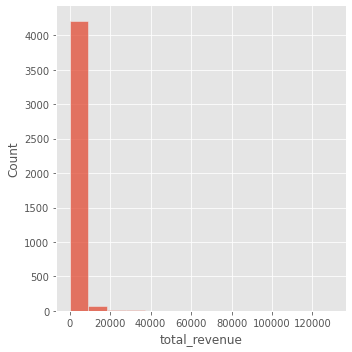

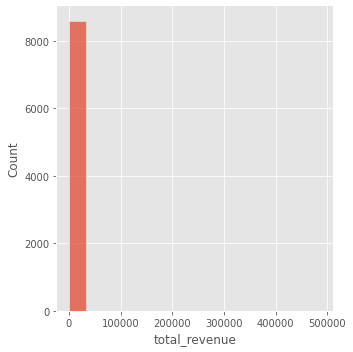

In [60]:
sns.displot(data = users_revenue_test)
sns.displot(data = users_revenue_control)

Посмотрим, как внедрение новой системы подписки повлияло на среднее значение выручки. Воспользуемся линейной регрессией, t-тестом, бутстрапом, непараметрическим тестом Манна-Уитни

Сформируем ряд, где категориальные переменные характеризуются попаданием пользователя либо в тестовую, либо в контрольную группу:

In [61]:
users_revenue = users[['group', 'total_revenue']].replace(['control_1', 'control_2'], 'control')
users_revenue.head()

,group,total_revenue
0,test,0
1,test,0
2,test,0
3,test,0
4,test,0


In [62]:
users_revenue_dummy = pd.get_dummies(data=users_revenue[['group', 'total_revenue']], drop_first = True)
results = smf.ols('total_revenue ~ group_test', users_revenue_dummy).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01111
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.916
Time:                        19:59:12   Log-Likelihood:            -1.2958e+05
No. Observations:               12912   AIC:                         2.592e+05
Df Residuals:                   12910   BIC:                         2.592e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    523.2107     59.562      8.784      0.0

Из результата видно, что значение средней выручки в контрольной группе равно 523,2107. Коэффициент у тестовой группы положителен и равен 10,8696, однако p_value равно 0,916 > 0.05. Можно сделать вывод, что влияние на среднюю выручку тестовой группы относительно контрольной группы незначительно.

Проверим нормальность распределений тестовой и контрольной группы:

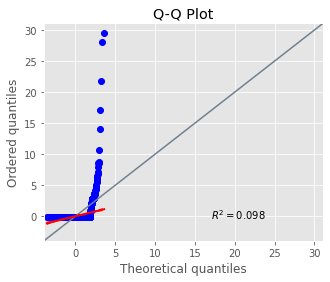

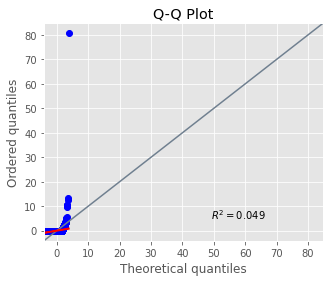

In [63]:
pg.qqplot(users_revenue_test)
pg.qqplot(users_revenue_control)

Как видно из Q-Q plot распределения ненормальны.

Проверка на гомогенность дисперсий тестовой и контрольных групп:

In [64]:
ss.levene(users_revenue_test, users_revenue_control)

LeveneResult(statistic=0.011111300162398665, pvalue=0.916051998389317)

По результату p_value теста Левена значительно больше 0,05 - дисперсии гомогенны

Проведем стат тесты между тестовой и контрольной группами

t-тест:

In [66]:
print(ss.ttest_ind(users_revenue_test, users_revenue_control))

Ttest_indResult(statistic=0.10541015208412644, pvalue=0.9160519983858973)


Непараметрический тест Манна-Уитни:

In [67]:
print(mannwhitneyu(users_revenue_test, users_revenue_control))

MannwhitneyuResult(statistic=18351812.0, pvalue=0.008012131871600096)


Бутстрап по средним:

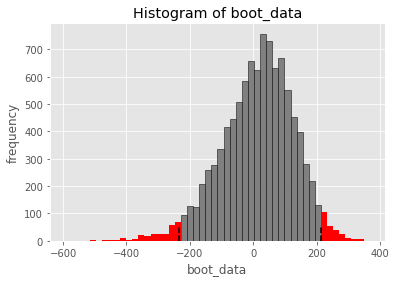

p_value = 0.910594999161393


In [68]:
boot_test_control = get_bootstrap_mean(users_revenue_test, users_revenue_control)
print(f'p_value = {boot_test_control["p_value"]}')

Итак, t-тест и бутстрап по средним значениям выручки не показал стат.значимых результатов, нулевую гипотезу о равенстве средних значений выручки в контрольной и тестовой группах отвергнуть нельзя.  

В тоже время критерий Манна-Уитни показал стат. значимый результат и следует отвергнуть нулевую гипотезу о равенстве распределений между тестовой и контрольными группами. 

Это может характеризоваться тем, что распределения групп не являются нормальными и присутствуют выбросы, которые влияют на результаты расчета t-теста и бутстрапа по среднему. С другой стороны, объемы выборок в тестовой группе и контрольной группе достаточно большие (4308 в тестовой и 8604 в контрольной), а также выполняется условие гомогенности дисперсий (проверено тестом Левена).  

Ввиду этого, можно сделать следующий вывод:  
*1. Принимаем нулевую гипотезу о равенстве средней выручки между тестовой и контрольными группами по результатам t-теста и бутстрапа;*  
*2. Принимаем во внимание, что по непараметрическому тесту Манна-Уитни мы должны отвергнуть нулевую гипотезу о равенстве распределений между тестовой и контрольными группами. Однако интерпретировать результат данного теста относительно влияния новой стоимости премиум-подписки сложно, поскольку этот тест проверяет только равенство распределений.* 

Исходя из результатов анализа, внедрять новую стоимость премиум - подписки на всех клиентах не стоит, по причине принятия нулевой гипотезы о равенстве средних.

### Посмотрим, повлияло ли изменение стоимости премиум - подписки на конверсию в премиум статусы и платящих пользователей

Конверсия в премиум клиента (was_premium):

In [70]:
users_cr_was_premium = users[['was_premium', 'group']].fillna(0).replace(['control_1', 'control_2'], 'control')
test_cr = users_cr_was_premium.query('group == "test"')
control_cr = users_cr_was_premium.query('group == "control"')

Подсчитаем количество пользователей, имевших статус was_premium и не имевших этого статуса по тестовой и контрольной группе.

In [71]:
test_cr_was_premium = test_cr.query('was_premium == 1').shape[0]
test_cr_not_premium = test_cr.shape[0] - test_cr_was_premium
control_cr_was_premium = control_cr.query('was_premium == 1').shape[0]
control_cr_not_premium = control_cr.shape[0] - control_cr_was_premium
T_was_premium = np.array([[test_cr_was_premium, test_cr_not_premium], [control_cr_was_premium, control_cr_not_premium]])
T_was_premium

array([[ 408, 3900],
       [ 847, 7757]])

Воспользуемся тестом Хи-квадрат:

In [72]:
res_pvalue = ss.chi2_contingency(T_was_premium)[1]
res_pvalue

0.5195350177767094

In [73]:
print(test_cr_was_premium / (test_cr_was_premium + test_cr_not_premium)*100)
print(control_cr_was_premium / (control_cr_was_premium + control_cr_not_premium)*100)

9.47075208913649
9.844258484425849


Стат.значимого результата не было выявлено. Новая система никак не изменила конверсию пользователей в статус was_premium

Конверсия в премиум клиента (is_premium):

In [74]:
users_cr_is_premium = users[['is_premium', 'group']].fillna(0).replace(['control_1', 'control_2'], 'control')
test_cr_ = users_cr_is_premium.query('group == "test"')
control_cr_ = users_cr_is_premium.query('group == "control"')

Подсчитаем количество пользователей, имевших статус is_premium и не имевших этого статуса по тестовой и контрольной группе.

In [75]:
test_cr_is_premium = test_cr_.query('is_premium == 1').shape[0]
test_cr_not_premium_ = test_cr_.shape[0] - test_cr_is_premium
control_cr_is_premium = control_cr_.query('is_premium == 1').shape[0]
control_cr_not_premium_ = control_cr_.shape[0] - control_cr_is_premium
T_is_premium = np.array([[test_cr_is_premium, test_cr_not_premium_], [control_cr_is_premium, control_cr_not_premium_]])
T_is_premium 

array([[ 157, 4151],
       [ 383, 8221]])

Воспользуемся тестом Хи-квадрат:

In [76]:
res_pvalue_is_premium = ss.chi2_contingency(T_is_premium)[1]
res_pvalue_is_premium

0.03456520670224254

In [77]:
print(test_cr_is_premium / (test_cr_is_premium + test_cr_not_premium_)*100)
print(control_cr_is_premium / (control_cr_is_premium + control_cr_not_premium_)*100)

3.6443825441039928
4.451417945141794


Выявлен стат. значимый результат, конверсия в is_premium в тестовой группе снизилась относительно контрольной группы.

Конверсия в платящего пользователя (т.е. совершившего транзакцию, total_revenue > 0)

In [78]:
users_cr_purchase = users[['total_revenue', 'group']].fillna(0).replace(['control_1', 'control_2'], 'control')
test_cr_purchase = users_cr_purchase.query('group == "test"')
control_cr_purchase = users_cr_purchase.query('group == "control"')

Подсчитаем кол-во платящих и не платящих пользователей:

In [79]:
test_cr_purchased = test_cr_purchase.query('total_revenue > 0').shape[0]
test_cr_not_purchased = test_cr_purchase.shape[0] - test_cr_purchased
control_cr_purchased = control_cr_purchase.query('total_revenue > 0').shape[0]
control_cr_not_purchased = control_cr_purchase.shape[0] - control_cr_purchased
T_purchased = np.array([[test_cr_purchased, test_cr_not_purchased], [control_cr_purchased, control_cr_not_purchased]])
T_purchased

array([[ 146, 4162],
       [ 379, 8225]])

Воспользуемся тестом Хи-квадрат:

In [80]:
res_pvalue = ss.chi2_contingency(T_purchased)[1]
res_pvalue

0.006755401507038141

In [81]:
print(test_cr_purchased / (test_cr_purchased + test_cr_not_purchased)*100)
print(control_cr_purchased / (control_cr_purchased + control_cr_not_purchased)*100)

3.3890436397400183
4.404927940492795


Выявлен стат. значимый результат, конверсия в платящего пользователя в тестовой группе снизилась относительно контрольной группы.

Стат.значимых результатов конверсии (was_premium) в тестовой и контрольной группах не зафиксировано. Конверсия для тестовой группы равна 9,47, для контрольной 9,84. В тоже время зафиксирован стат.значимый результат конверсии (is_premium), причем для тестовой группы он равен 3,64, а для контрольной 4,45, что говорит о том, что пользователи контрольной группы дольше находятся в стадии is_premium, чем в тестовой. Кроме того, конверсия в платящего пользователя в тестовой группе также стат.значимо снизилась относительно контрольной (3,39 и 4,41 соотв.).  

Поскольку по условию задачи поменялась только стоимость оплаты премиум-подписки, можно предположить, что это могло повлиять на решение пользователей оставаться в статусе премиум.  


# Общий вывод

Анализ полученных результатов позволил сделать следующие выводы:
1. Внедрять новую стоимость премиум - подписки на всех клиентах не стоит по причине принятия нулевой гипотезы о равенстве средних значений выручки;
2. Среди пользователей с новой стоимостью премиум подписки снизилась конверсия в платящего пользователя, а также в конверсию is_premium;  
3. Непараметрический тест Манна-Уитни показал стат.значимый результат между тестовой и контрольной группами. Однако, однозначно интерпретировать результат данного теста с точки зрения влияния новой стоимости премиум-подписки сложно, поскольку этот тест проверяет только равенство распределений;
4. Возможно, стоит провести более детальный анализ пользователей, определить среди них интересующие группы (например, по возрасту, стране, наличию транзакций и т.д.) и провести повторный эксперимент на этих группах.